# Milestone 2

## 1. Data cleaning and preprocessing

In [1]:
#we import all the necessary librairies here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
import os


In [2]:
#data paths
data_path = './data/'
cmu_path = data_path+'MovieSummaries/'
acl_persona_path = data_path+'ACL_personas_dump/personas/'

#### 1.1 Movie dataset

Let's first have a look at the cmu movie dataset more in details to see what we can do with it.

In [3]:
#Import the cmu movie dataset and print a sample of 5 random row in the dataset
cmu_movie_cols = ['wikiID',
                  'freebase_movID',
                  'movie_name',
                  'release_date',
                  'boxoffice',
                  'runtime',
                  'language',
                  'country',
                  'genre']

cmu_movies = pd.read_csv(cmu_path+'movie.metadata.tsv', sep='\t', names=cmu_movie_cols)
cmu_movies.sample(5)

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre
35178,28223867,/m/07l4_10,"Hugh Hefner: Playboy, Activist and Rebel",2010-07-30,10000.0,135.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}","{""/m/0hj3n07"": ""Culture & Society"", ""/m/017fp""..."
65618,7731316,/m/0kvg4h,Vijetha,1985-10-23,NaN,141.0,"{""/m/09s02"": ""Telugu language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",..."
12957,33545699,/m/0hgpwpl,The Shadow Between,1920,NaN,NaN,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/06ppq"": ""Sil..."
15119,22255365,/m/05q82jr,Enid,2009,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/07s9rl0"": ""Drama""}"
63693,24008761,/m/07kfj9d,Bedari,1957,NaN,NaN,"{""/m/02hxcvy"": ""Urdu Language""}","{""/m/05sb1"": ""Pakistan""}","{""/m/0hqxf"": ""Family Film"", ""/m/07s9rl0"": ""Dra..."


In [4]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikiID          81741 non-null  int64  
 1   freebase_movID  81741 non-null  object 
 2   movie_name      81741 non-null  object 
 3   release_date    74839 non-null  object 
 4   boxoffice       8401 non-null   float64
 5   runtime         61291 non-null  float64
 6   language        81741 non-null  object 
 7   country         81741 non-null  object 
 8   genre           81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


The first thing we see here is that we do not have a lot of boxoffice data for the movies. However we need a way to asses the success of a movie for our analysis. 

To solve that issue we decided that we will use the imdb rating as a proxy for the success of a movie. We will also use the number of votes as a proxy for the popularity of a movie.

In [5]:
# As the dataset is pretty big, we won't bother importing columns that we don't need later to save memory space
col_to_load = ['tconst','primaryTitle','startYear']
col_dtype = {'tconst': str, 'primaryTitle': str, 'startYear': 'Int64'}
imdb_movies = pd.read_csv(data_path+'title_basics.tsv', usecols=col_to_load, sep='\t', na_values=['\\N'], dtype=col_dtype)

# As this dataset is a way for us to get the title of the rating dataset, we will drop all the rows that have NaN values 
# in the primaryTitle column.
imdb_movies.dropna(subset=['primaryTitle'], inplace=True)
imdb_movies.sample(5)

,tconst,primaryTitle,startYear
8039928,tt4877642,Episode dated 9 June 2014,2014
9607911,tt8368360,Double Addicted with Kira Thorn & Victoria J B...,2018
7330227,tt3261918,Quietly Into the Night,2013
4131125,tt15801536,Amur - Fluss zwischen zwei Weltreichen,2003
5094921,tt1980298,Wild Hungary - A Water Wonderland,2011


Now let's import ratings and combine the two to have a new dataset containings the title of the movie and its rating.

In [6]:
imdb_ratings= pd.read_csv(data_path+'title_ratings.tsv', sep='\t')
imdb_ratings.sample(5)

,tconst,averageRating,numVotes
137036,tt0211477,6.0,42
372890,tt0744341,7.9,17
1080161,tt4122680,8.4,1706
1352503,tt9377142,7.5,63
688485,tt14578402,8.2,7


In [7]:
imdb_movies_ratings = imdb_movies.merge(imdb_ratings,how='inner',on='tconst')
imdb_movies_ratings.sample(5)

,tconst,primaryTitle,startYear,averageRating,numVotes
626734,tt1330984,Bunte Träume,2004,8.1,15
398549,tt0814494,Femme de ménage,2000,8.8,7
570093,tt1214193,Noc zivih mrtvaca,2008,8.3,16
720876,tt1528432,Is That a Baby in Your Pants?,2009,9.7,8
131412,tt0199696,Slow at Heart,2000,6.0,63


Now that we have a dataset with the title of the movie and its rating, we can clean the duplicates and the movies with no rating.

In [8]:
imdb_movies_ratings.primaryTitle = imdb_movies_ratings.primaryTitle.str.lower()
imdb_movies_ratings.drop_duplicates(subset=['primaryTitle','startYear'],inplace=True)
imdb_movies_ratings.dropna(subset=['averageRating'], inplace=True)

Now let's merge it to the cmu dataset in order to have a dataset with all the information we need.

In [9]:
#first we lower the title also in the cmu dataset
cmu_movies.movie_name = cmu_movies.movie_name.str.lower()

#then we gather the release year of the movies in the cmu dataset
cmu_movies['release_year'] = pd.to_numeric(cmu_movies.release_date.astype(str).str[:4], errors='coerce').astype('Int64')
cmu_movies.dropna(subset=['release_year'], inplace=True)

cmu_imdb_movies = cmu_movies.merge(imdb_movies_ratings,left_on=['movie_name','release_year'],right_on=['primaryTitle','startYear'])
cmu_movies = cmu_imdb_movies.drop(columns=['tconst','primaryTitle','startYear','release_year']).copy()
cmu_movies

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre,averageRating,numVotes
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,56933
1,28463795,/m/0crgdbh,brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",5.6,41
2,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",6.1,2899
3,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",5.9,623
4,13696889,/m/03cfc81,the gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",6.8,17
...,...,...,...,...,...,...,...,...,...,...,...
49987,15394941,/m/03m6zh4,gopi kishan,1994-12-02,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama"", ""/m/02kdv5l"": ""Action""...",5.8,965
49988,23851782,/m/06_vb43,the ghost train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",6.2,1582
49989,35228177,/m/0j7hxnt,mermaids: the body found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",4.6,1711
49990,34980460,/m/0g4pl34,knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",6.8,3194


Now that we have all the information we need, we can start working on making the dataset more usable for our analysis.

In [10]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49992 entries, 0 to 49991
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikiID          49992 non-null  int64  
 1   freebase_movID  49992 non-null  object 
 2   movie_name      49992 non-null  object 
 3   release_date    49992 non-null  object 
 4   boxoffice       7463 non-null   float64
 5   runtime         41922 non-null  float64
 6   language        49992 non-null  object 
 7   country         49992 non-null  object 
 8   genre           49992 non-null  object 
 9   averageRating   49992 non-null  float64
 10  numVotes        49992 non-null  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 4.2+ MB


As we can see here the date are not in a very usable format. We will need to convert them to a datetime format.

In [11]:
cmu_movies['release_date'] = cmu_movies['release_date'].apply(pd.to_datetime)

#we check if we have coherent date
cmu_movies.release_date.describe()

count                            49992
mean     1979-02-19 06:43:57.349975936
min                1888-01-01 00:00:00
25%                1957-02-13 18:00:00
50%                1987-01-01 00:00:00
75%                2003-10-24 00:00:00
max                2016-03-18 00:00:00
Name: release_date, dtype: object

We will now check the distribution of the movies we have through the years. and we will drop the one that have too few movies.

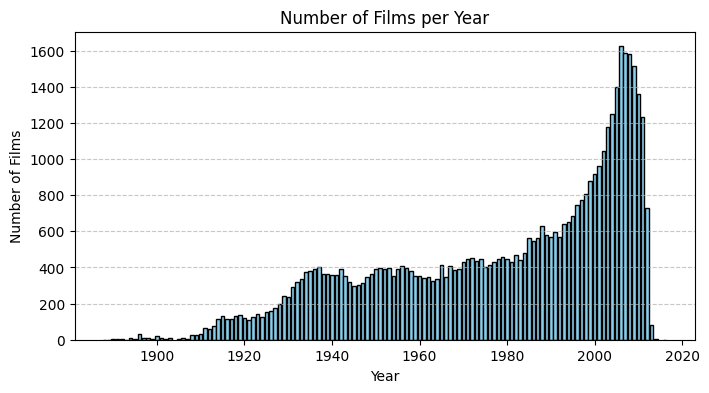

In [12]:
grouped_year = cmu_movies.groupby(cmu_movies.release_date.dt.year).agg(number_films=('movie_name','count')).reset_index()

plt.figure(figsize=(8, 4))
plt.bar(grouped_year['release_date'], grouped_year['number_films'], color='skyblue', edgecolor='black')
plt.title('Number of Films per Year')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It seems the number of movies per year increases with years. Let's see a bit more in details how many years have less than 100, 500, 1000 movies.

In [13]:
# Print the years with less than 100, 500, and 1000 films
years_less_than_100 = grouped_year[grouped_year['number_films'] < 100]['release_date']
years_less_than_500 = grouped_year[grouped_year['number_films'] < 500]['release_date']
years_less_than_1000 = grouped_year[grouped_year['number_films'] < 1000]['release_date']

print(f'Number of years with less than 100 films: {len(years_less_than_100)}')
print(f'Number of years with less than 500 films: {len(years_less_than_500)}')
print(f'Number of years with less than 1000 films: {len(years_less_than_1000)}')

# Print the year with the max number of movies
max_films_year = grouped_year.loc[grouped_year['number_films'].idxmax(), 'release_date']
max_films_count = grouped_year['number_films'].max()
print(f'The year with the max number of films is: {max_films_year:.0f} with {max_films_count} films')

Number of years with less than 100 films: 28
Number of years with less than 500 films: 99
Number of years with less than 1000 films: 117
The year with the max number of films is: 2006 with 1624 films


We see that there are not that much years with less than 100 movies. We will drop them from our dataset, in order to have more significant results when we will do year based analysis.

In [14]:
# In the original CMU dataset remove the rows with release year with less than 100 films
years_to_remove = grouped_year[grouped_year['number_films'] < 100]['release_date'].tolist()
cmu_movies = cmu_movies[~cmu_movies.release_date.dt.year.isin(years_to_remove)].copy()


# Test if the rows have been removed
print(f'The minimum number of film in a year is {cmu_movies.release_date.dt.year.value_counts().min()} in year {cmu_movies.release_date.dt.year.value_counts().idxmin()}')

The minimum number of film in a year is 111 in year 1921


We have also the problem that for the moment the values in the columns 'language', 'country' and 'genre' are still in a object format and not easily usable. We will need to convert them to a more usable format. For an easy access to those values later we will interpret them as dictionaries that we'll convert to a list format since we do not need the keys.

In [15]:
# Transform the object dtype into list of values:
# We use ast.literal_eval to interpret the string as a dictionnaries, we take only their values and we convert it to a list
cmu_movies['language'] = cmu_movies['language'].apply(lambda x: list(ast.literal_eval(x).values())) 
cmu_movies['country'] = cmu_movies['country'].apply(lambda x: list(ast.literal_eval(x).values()))
cmu_movies['genre'] = cmu_movies['genre'].apply(lambda x: list(ast.literal_eval(x).values()))

# Check the max number of values in each list (i.e. the max number of languages, countries and genres for a movie)
print(f'The max number of values in a single list for language is {cmu_movies["language"].apply(len).max()}')
print(f'The max number of values in a single list for country is {cmu_movies["country"].apply(len).max()}')
print(f'The max number of values in a single list for genre is {cmu_movies["genre"].apply(len).max()}')
cmu_movies

The max number of values in a single list for language is 11
The max number of values in a single list for country is 14
The max number of values in a single list for genre is 17


,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre,averageRating,numVotes
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",4.9,56933
1,28463795,/m/0crgdbh,brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",5.6,41
2,9363483,/m/0285_cd,white of the eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",6.1,2899
3,261236,/m/01mrr1,a woman in flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],5.9,623
5,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",6.8,2270
...,...,...,...,...,...,...,...,...,...,...,...
49987,15394941,/m/03m6zh4,gopi kishan,1994-12-02,NaN,NaN,[Hindi Language],[India],"[Drama, Action, Crime, Comedy]",5.8,965
49988,23851782,/m/06_vb43,the ghost train,1941-05-03,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",6.2,1582
49989,35228177,/m/0j7hxnt,mermaids: the body found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],4.6,1711
49990,34980460,/m/0g4pl34,knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",6.8,3194


#### 1.2 Characters dataset

Now that we have a usable and clean dataset for the movies we will interest ourselves to the character dataset. To do that let first have a look at the dataset.

In [16]:
cmu_character_cols = ['wikiID',
                      'freebase_movID',
                      'release_date',
                      'character_name',
                      'actor_birth',
                      'actor_gender',
                      'actor_height',
                      'actor_ethnicity',
                      'actor_name',
                      'actor_age_at_release',
                      'freebase_char_actor_map',
                      'freebase_charID',
                      'freebase_actorID']

cmu_character = pd.read_table(cmu_path+'character.metadata.tsv', names=cmu_character_cols)
cmu_character.sample(5)

,wikiID,freebase_movID,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID
21353,1598996,/m/05fkxp,1998-05-29,Shaquinna,1971-06-18,F,1.67,NaN,Lisa Barbuscia,26.0,/m/0jtblw,/m/0h6f2jv,/m/07dvnb
155214,3850349,/m/0b3717,1949-07-01,Irene Bennett,1917-06-30,F,1.60,/m/065b6q,Susan Hayward,32.0,/m/0jzlhv,/m/0h5b_db,/m/01938t
187492,12705564,/m/02x1cmy,1954,Marc Anthony's master,1914-10-06,M,NaN,NaN,Robert C. Bruce,39.0,/m/0gb0_2d,/m/0hynn13,/m/0grrpl
7090,1815818,/m/05z5cp,1988-10-10,"Father, as child",NaN,F,NaN,NaN,Liu Jia,NaN,/m/0k2f07,/m/0g4pq7_,/m/0k2d_2
85980,30088768,/m/0gj9qxr,2011-03,Creature Performer,NaN,M,NaN,NaN,Terry Notary,NaN,/m/0gxgw56,/m/0h7gkjt,/m/0gxgw58


In [17]:
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   wikiID                   450669 non-null  int64  
 1   freebase_movID           450669 non-null  object 
 2   release_date             440674 non-null  object 
 3   character_name           192794 non-null  object 
 4   actor_birth              344524 non-null  object 
 5   actor_gender             405060 non-null  object 
 6   actor_height             154824 non-null  float64
 7   actor_ethnicity          106058 non-null  object 
 8   actor_name               449441 non-null  object 
 9   actor_age_at_release     292556 non-null  float64
 10  freebase_char_actor_map  450669 non-null  object 
 11  freebase_charID          192804 non-null  object 
 12  freebase_actorID         449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


We will first drop any null value we have on the wikiID column or in the freebase_actorID column since we don't want character without actor or movie, we also drop the dupplicates if we have more than one character for the same actor in the same movie.

In [18]:
cmu_character.dropna(subset=['wikiID','freebase_actorID'], inplace=True)
cmu_character.drop_duplicates(subset=['wikiID','freebase_actorID'], inplace=True)
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
Index: 446442 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   wikiID                   446442 non-null  int64  
 1   freebase_movID           446442 non-null  object 
 2   release_date             436524 non-null  object 
 3   character_name           189091 non-null  object 
 4   actor_birth              341529 non-null  object 
 5   actor_gender             401689 non-null  object 
 6   actor_height             153132 non-null  float64
 7   actor_ethnicity          104568 non-null  object 
 8   actor_name               446029 non-null  object 
 9   actor_age_at_release     289848 non-null  float64
 10  freebase_char_actor_map  446442 non-null  object 
 11  freebase_charID          189100 non-null  object 
 12  freebase_actorID         446442 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 47.7+ MB


We can see that we didn't loose to much data. We will now create a dataset containing the information about the actors and the movies they played in.

In [19]:
actor_movie = cmu_character.drop(columns='release_date', axis=1).merge(cmu_movies[['wikiID','averageRating','numVotes','release_date']],on='wikiID',how='inner')
actor_movie

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,averageRating,numVotes,release_date
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,4.9,56933,2001-08-24
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,4.9,56933,2001-08-24
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,4.9,56933,2001-08-24
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,4.9,56933,2001-08-24
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,4.9,56933,2001-08-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331122,9971909,/m/02pygw1,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5,5.8,112,1972-09-22
331123,9971909,/m/02pygw1,NaN,1918-10-02,M,NaN,NaN,Herb Voland,53.0,/m/0ggdv2_,NaN,/m/02qylb9,5.8,112,1972-09-22
331124,28308153,/m/0cp05t9,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,7.2,28,1957-01-01
331125,28308153,/m/0cp05t9,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,7.2,28,1957-01-01


We will now compute a fame score for each actor basing ourselves on the three previous movies he played in in order the have for every actor a first carreer sucess indicator. This is subject to change but for the first milestone this first version of the fame score is satisfying.

We First define a function to compute this fame score and then we apply it to our dataset.

In [20]:
def fame_score(row,data):
    n = row['index']
    rowm1 = data.iloc[n-1]
    rowm2 = data.iloc[n-2]

    actor = row['freebase_actorID']
    year = row['release_date'].year
    rate = row['averageRating']
    votes = row['numVotes']

    fame_score = rate * np.log(votes) / (year-1700)

    if rowm2['freebase_actorID'] == actor:
        year = rowm2['release_date'].year
        rate = rowm2['averageRating'] 
        votes = rowm2['numVotes']
        fame_score += rate * np.log(votes) / (year-1700)

    if rowm1['freebase_actorID'] == actor:
        year = rowm1['release_date'].year
        rate = rowm1['averageRating']
        votes = rowm1['numVotes']
        fame_score += rate * np.log(votes) / (year-1700)

    return fame_score

In [21]:
# For our function to work we need to have a sorted dataset
actor_movie.sort_values(by=['freebase_actorID','release_date'], inplace=True)
actor_movie.reset_index(drop=True,inplace=True)
actor_movie.reset_index(inplace=True)

In [22]:
# Apply the function to each row
actor_movie['fameScore'] = actor_movie.apply(lambda x: fame_score(x,actor_movie), axis=1)
actor_movie.drop('index',inplace=True,axis=1)
actor_movie

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,averageRating,numVotes,release_date,fameScore
0,26147476,/m/0b6jfrc,Mike's Stupid Boss,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,34.0,/m/0gy5tc8,/m/0gy5tcb,/m/010p3,6.0,3554,1999-01-01,0.164063
1,4209429,/m/0bq2wj,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0h41kvc,NaN,/m/010p3,6.2,5390,2000-01-01,0.341638
2,20619519,/m/051wrdv,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0cvctbl,NaN,/m/010p3,4.5,862,2000-01-01,0.443027
3,2981197,/m/08hjr9,'The Man Show' Host,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0gy5t9q,/m/0gy5t9s,/m/010p3,5.0,15586,2000-01-21,0.439865
4,7197477,/m/0kv065,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,38.0,/m/03lsx30,NaN,/m/010p3,7.4,2141,2003-01-01,0.449587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331122,31024173,/m/0gg5qcw,Tom Duffy,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0gk8xfg,/m/0gvdm_6,/m/0zcbl,7.1,228346,2011-08-31,0.740218
331123,30431590,/m/0h33rzv,Arnie,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0n3ypdx,/m/0hgfgdz,/m/0zcbl,6.3,39860,2012-01-23,0.704980
331124,31734473,/m/0gtvrv3,Benno Levin,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0bvdd_d,/m/0h27z5r,/m/0zcbl,5.1,49534,2012-05-25,0.672294
331125,31306385,/m/0gj8t_b,Paul Gill,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,45.0,/m/0gljb0n,/m/0gwg8hc,/m/0zcbl,5.9,80839,2012-06-15,0.604298


We want now to repopulate our dataframe with the info we lost because we chose too ??? CHECKED THIS WEIRD MANIPULATION WHY NOT KEEPING ALL THE COLUMNS FIRST

In [23]:
cmu_character = actor_movie.drop(columns=['averageRating','numVotes']).copy()
cmu_character

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,fameScore
0,26147476,/m/0b6jfrc,Mike's Stupid Boss,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,34.0,/m/0gy5tc8,/m/0gy5tcb,/m/010p3,1999-01-01,0.164063
1,4209429,/m/0bq2wj,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0h41kvc,NaN,/m/010p3,2000-01-01,0.341638
2,20619519,/m/051wrdv,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0cvctbl,NaN,/m/010p3,2000-01-01,0.443027
3,2981197,/m/08hjr9,'The Man Show' Host,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0gy5t9q,/m/0gy5t9s,/m/010p3,2000-01-21,0.439865
4,7197477,/m/0kv065,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,38.0,/m/03lsx30,NaN,/m/010p3,2003-01-01,0.449587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331122,31024173,/m/0gg5qcw,Tom Duffy,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0gk8xfg,/m/0gvdm_6,/m/0zcbl,2011-08-31,0.740218
331123,30431590,/m/0h33rzv,Arnie,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0n3ypdx,/m/0hgfgdz,/m/0zcbl,2012-01-23,0.704980
331124,31734473,/m/0gtvrv3,Benno Levin,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0bvdd_d,/m/0h27z5r,/m/0zcbl,2012-05-25,0.672294
331125,31306385,/m/0gj8t_b,Paul Gill,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,45.0,/m/0gljb0n,/m/0gwg8hc,/m/0zcbl,2012-06-15,0.604298


Now that we a cleaned dataset of character with the corresponding fame score of each actor, we would like that have more information on the character the actor is playing in this movie. For that we will use the persona dataset form the paper to be able later to understand the relation between the character and the actor. 

In [24]:
acl_persona_cols = ['entity_id',
                    'wikiID',
                    'movie_name',
                    'entity_name',
                    'full_entity_name',
                    'entity_num_event',
                    'persona',
                    'final_posterior']

acl_persona = pd.read_table(acl_persona_path+'25.100.lda.log.txt', header=None, names=acl_persona_cols)
acl_persona

,entity_id,wikiID,movie_name,entity_name,full_entity_name,entity_num_event,persona,final_posterior
0,e7,10000053,The Trap,she,her,5,13,0.00000 0.02000 0.02000 0.00000 0.00000 0.0000...
1,e8,10000053,The Trap,she,her,5,12,0.00000 0.12000 0.07000 0.01000 0.00000 0.0000...
2,e12,10000053,The Trap,he,his,7,41,0.00000 0.01000 0.02000 0.02000 0.00000 0.0100...
3,e19,10000053,The Trap,she,her,6,1,0.00000 0.65000 0.04000 0.00000 0.00000 0.0100...
4,e4,10000053,The Trap,Eve,Eve,11,23,0.00000 0.13000 0.05000 0.01000 0.00000 0.0100...
...,...,...,...,...,...,...,...,...
178729,e11,99984,Una Aventura Llamada Menudo,Concepci,Danny Concepci,3,12,0.00000 0.01000 0.14000 0.04000 0.00000 0.0200...
178730,e10,99984,Una Aventura Llamada Menudo,he,the son of C sar Concepci n Jr.,4,23,0.00000 0.02000 0.07000 0.15000 0.00000 0.0000...
178731,e1,99984,Una Aventura Llamada Menudo,they,their,6,35,0.00000 0.01000 0.21000 0.05000 0.00000 0.0000...
178732,e0,9999280,Plaza de Almas,he,his,6,2,0.00000 0.00000 0.87000 0.02000 0.00000 0.0000...


We want now to populate our cmu_character dataframe with those infos about the personas.

In [25]:
#We first need to keep only the entities detected that have a freebase_char_actor_map value in order to be able to merge it with the other df WHY?
cmu_character = cmu_character.merge(acl_persona[['entity_id','persona']], left_on='freebase_char_actor_map', right_on='entity_id', how='left').drop(columns='entity_id')
cmu_character

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,fameScore,persona
0,26147476,/m/0b6jfrc,Mike's Stupid Boss,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,34.0,/m/0gy5tc8,/m/0gy5tcb,/m/010p3,1999-01-01,0.164063,NaN
1,4209429,/m/0bq2wj,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0h41kvc,NaN,/m/010p3,2000-01-01,0.341638,NaN
2,20619519,/m/051wrdv,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0cvctbl,NaN,/m/010p3,2000-01-01,0.443027,NaN
3,2981197,/m/08hjr9,'The Man Show' Host,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,35.0,/m/0gy5t9q,/m/0gy5t9s,/m/010p3,2000-01-21,0.439865,NaN
4,7197477,/m/0kv065,NaN,1964-05-27,M,1.880,/m/0xnvg,Adam Carolla,38.0,/m/03lsx30,NaN,/m/010p3,2003-01-01,0.449587,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331136,31024173,/m/0gg5qcw,Tom Duffy,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0gk8xfg,/m/0gvdm_6,/m/0zcbl,2011-08-31,0.740218,2.0
331137,30431590,/m/0h33rzv,Arnie,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0n3ypdx,/m/0hgfgdz,/m/0zcbl,2012-01-23,0.704980,NaN
331138,31734473,/m/0gtvrv3,Benno Levin,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,44.0,/m/0bvdd_d,/m/0h27z5r,/m/0zcbl,2012-05-25,0.672294,NaN
331139,31306385,/m/0gj8t_b,Paul Gill,1967-06-06,M,1.740,/m/033tf_,Paul Giamatti,45.0,/m/0gljb0n,/m/0gwg8hc,/m/0zcbl,2012-06-15,0.604298,49.0


In [26]:
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331141 entries, 0 to 331140
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   wikiID                   331141 non-null  int64         
 1   freebase_movID           331141 non-null  object        
 2   character_name           151495 non-null  object        
 3   actor_birth              255790 non-null  object        
 4   actor_gender             299200 non-null  object        
 5   actor_height             122668 non-null  float64       
 6   actor_ethnicity          80728 non-null   object        
 7   actor_name               330847 non-null  object        
 8   actor_age_at_release     225078 non-null  float64       
 9   freebase_char_actor_map  331141 non-null  object        
 10  freebase_charID          151500 non-null  object        
 11  freebase_actorID         331141 non-null  object        
 12  release_date    

## 2. First Data analysis

### 2.1 Feats Analysis

We will start by digging into the impact of the other actors on your own fame. Casting a movie with a celebrity may bring light on a rising star and contribute to its success. For example, in the plots below, to what extent did Andy Serkis playing Gollum in the Lord of the Rings benefitted in fame from playing with Cate Blanchett, as Galadriel, in that movie knowing that Cate Blanchett has a fame score among the 100 best ones in previous years.

In [27]:
def plot_filmography(actor_name):
    '''
    This function plots the fame score of an actor along the years and the movies he played in
    '''
    
    filmography = cmu_character.query(f"actor_name=='{actor_name}'").sort_values('release_date')
    filmography = filmography.merge(cmu_movies[['wikiID','movie_name']], on='wikiID')
    
    plt.figure(figsize=(10,5))
    for i,film in filmography.iterrows():
        plt.scatter(film.release_date, film.fameScore, label=str(i+1)+' : '+film.movie_name, color='cornflowerblue')
        plt.annotate(i+1, xy=(film['release_date'],film['fameScore']), xytext=(4,0), textcoords='offset points')
    plt.xlabel('Year')
    plt.ylabel('Fame score')
    plt.title(f'Fame score for {actor_name} along years')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))


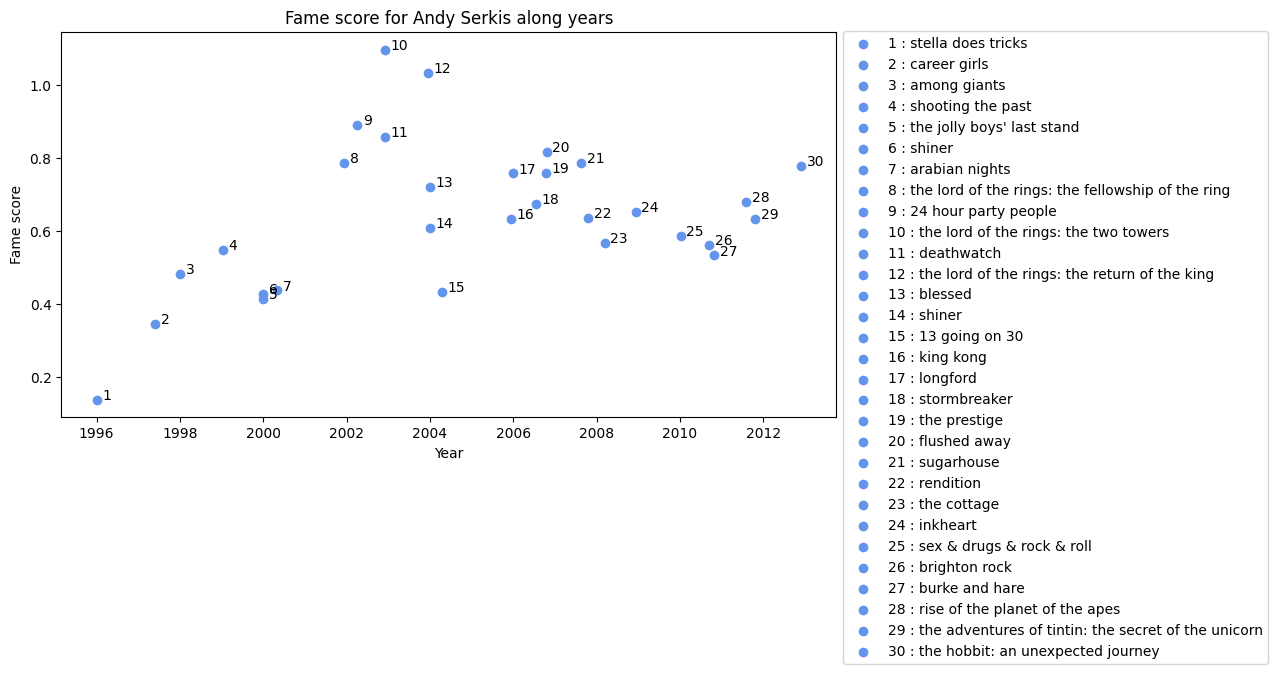

In [28]:
plot_filmography('Andy Serkis')

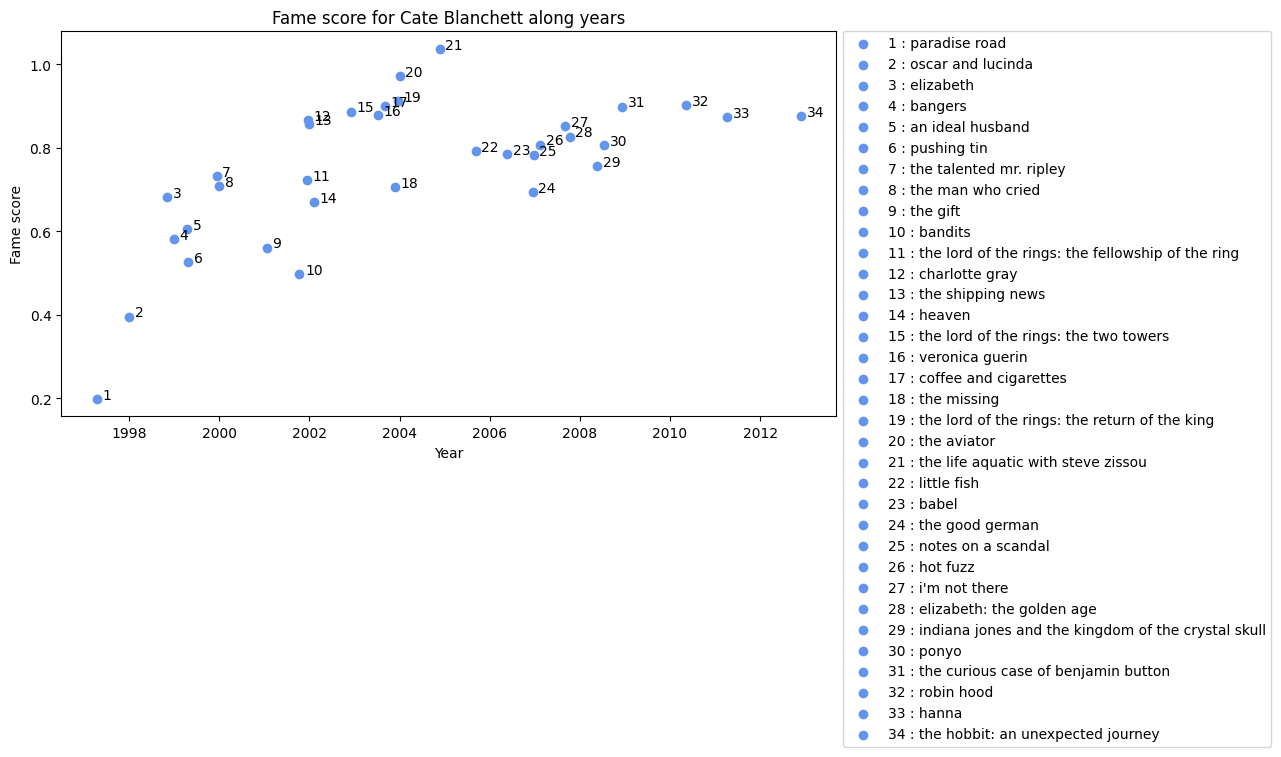

In [29]:
plot_filmography('Cate Blanchett')

Let's compute for each year the 100 most famous actresses and actors, that we think may be carreer or fame boosters for their colleagues.

In [30]:
def get_top100_actor(df):
    '''
    This function returns the top 100 actors with the highest fame score for each year
    '''

    # drop duplicates in case actor has several films in same year, keep the best fameScore attained that year
    df=df.sort_values(['freebase_actorID','fameScore']).drop_duplicates(subset='freebase_actorID', keep='last') 
    return df.iloc[np.argsort(df.fameScore.values)[-100:],:]

top100_actor_year=cmu_character.groupby(cmu_character.release_date.dt.year)[['wikiID','actor_name','freebase_actorID','fameScore']] \
                               .apply(get_top100_actor) \
                               .reset_index(level=0)
top100_actor_year.head()

,release_date,wikiID,actor_name,freebase_actorID,fameScore
305524,1914,21254215,David Hartford,/m/0j9v5hd,0.156015
325773,1914,21254215,Louise Dunlap,/m/0mwj6ht,0.156015
24434,1914,21254215,Richard Garrick,/m/01s_qj,0.156015
325771,1914,21254215,H.L. Griffith,/m/0mwj6h3,0.156015
325772,1914,21254215,H.R. Macy,/m/0mwj6hg,0.156015


As we are interested in fame increases or decreases, we compute the fame's difference before and after portraying in a film. The fame score is computed using at most 3 past films, we then filter out the first 3 values to keep meaningful variations.

In [31]:
def get_fame_diff(df):
    '''
    This function returns the fame score variation for an actor between two films
    '''

    # check that we have enough films for that actor (if actor have less than 3 films we don't have a representative fameScore)
    # returns dataframe with fame variation for film i, removing first 3 values
    if df.shape[0]>3:
        df.sort_values('release_date', inplace=True)
        return pd.DataFrame({'fameScore_diff': (df.fameScore.values[1:] - df.fameScore.values[:-1])[2:], 
                             'release_date' : df.release_date[3:], 'wikiID' : df.wikiID[3:]})

actor_fame_diff = cmu_character.loc[cmu_character.release_date.dt.day!=1, ['wikiID','freebase_actorID','fameScore','release_date']]
actor_fame_diff = actor_fame_diff.groupby('freebase_actorID') \
                                 .apply(get_fame_diff) \
                                 .reset_index(level=0)
actor_fame_diff.head()

,freebase_actorID,fameScore_diff,release_date,wikiID
17,/m/010xjr,-0.110260,1966-10-10,1591985
18,/m/010xjr,-0.076258,1967-04-18,10469675
19,/m/010xjr,-0.003423,1967-10-25,3493076
22,/m/010xjr,0.096909,1970-04-28,10542198
24,/m/010xjr,-0.089860,1973-12-21,27768319


We now want to create a table of featuring, where we will have for each actor an entry corresponding to an actor he played with in order to know the different connection between actors we have over the years.

In [32]:
# create dataframe actor_feats linking an actor 1 benefitting from casting with an actor 2 (reverse relation is also present in dataframe)
actor_feats = cmu_character[['wikiID','actor_name','freebase_actorID','release_date']]
actor_feats = actor_feats.merge(actor_feats, on=['wikiID','release_date'])
actor_feats.columns = ['wikiID','actor_name_1','freebase_actorID_1','release_date','actor_name_2','freebase_actorID_2']

# remove feats with itself
actor_feats = actor_feats[actor_feats.freebase_actorID_1!=actor_feats.freebase_actorID_2]
actor_feats.head()

,wikiID,actor_name_1,freebase_actorID_1,release_date,actor_name_2,freebase_actorID_2
1,26147476,Adam Carolla,/m/010p3,1999-01-01,Kathleen Robertson,/m/02l74w
2,26147476,Adam Carolla,/m/010p3,1999-01-01,Kelly Macdonald,/m/02tr7d
3,26147476,Adam Carolla,/m/010p3,1999-01-01,Johnathon Schaech,/m/076bgw
4,26147476,Adam Carolla,/m/010p3,1999-01-01,Eric Mabius,/m/07j844
5,26147476,Adam Carolla,/m/010p3,1999-01-01,Matt Keeslar,/m/0dx9mn


We need now to retrieve the fame score variation for the actor1 corresponding to the collaboration he made with the actor2.

In [33]:
# Merge on actor 1 in the feats with actor_fame_diff to get its fame variations
actor_feats = actor_feats.merge(actor_fame_diff, left_on=['wikiID','freebase_actorID_1','release_date'], 
                                right_on=['wikiID','freebase_actorID','release_date']) \
                         .drop(columns='freebase_actorID', axis=1)
actor_feats.head()

,wikiID,actor_name_1,freebase_actorID_1,release_date,actor_name_2,freebase_actorID_2,fameScore_diff
0,2981197,Selma Blair,/m/01mqh5,2000-01-21,Adam Carolla,/m/010p3,0.007369
1,2981197,Selma Blair,/m/01mqh5,2000-01-21,Ashton Kutcher,/m/01p4vl,0.007369
2,2981197,Selma Blair,/m/01mqh5,2000-01-21,Jimmy Kimmel,/m/02238b,0.007369
3,2981197,Selma Blair,/m/01mqh5,2000-01-21,Henry Winkler,/m/024jwt,0.007369
4,2981197,Selma Blair,/m/01mqh5,2000-01-21,Rosario Dawson,/m/02_hj4,0.007369


We now want to have the information on is the feat a feat with a "famous" actor (corresponding to our criteria it is the top100 famous actor of each year). 

In [34]:
# Apply a left join on actor_feats with the top100 actors on actor 2 of actor_feats as it is the one from which actor 1 benefits
# Left join allows to put NaNs when no match indicating that this feat between actors does not contain a famous ones
actor_feats = actor_feats.merge(top100_actor_year[['wikiID','freebase_actorID']], \
                                left_on=['wikiID','freebase_actorID_2'], \
                                right_on=['wikiID','freebase_actorID'], how='left') \
                         .rename(columns={'freebase_actorID':'with_top100'})
actor_feats['with_top100'] = ~actor_feats['with_top100'].isna()

actor_feats.head()

,wikiID,actor_name_1,freebase_actorID_1,release_date,actor_name_2,freebase_actorID_2,fameScore_diff,with_top100
0,2981197,Selma Blair,/m/01mqh5,2000-01-21,Adam Carolla,/m/010p3,0.007369,False
1,2981197,Selma Blair,/m/01mqh5,2000-01-21,Ashton Kutcher,/m/01p4vl,0.007369,False
2,2981197,Selma Blair,/m/01mqh5,2000-01-21,Jimmy Kimmel,/m/02238b,0.007369,False
3,2981197,Selma Blair,/m/01mqh5,2000-01-21,Henry Winkler,/m/024jwt,0.007369,False
4,2981197,Selma Blair,/m/01mqh5,2000-01-21,Rosario Dawson,/m/02_hj4,0.007369,False


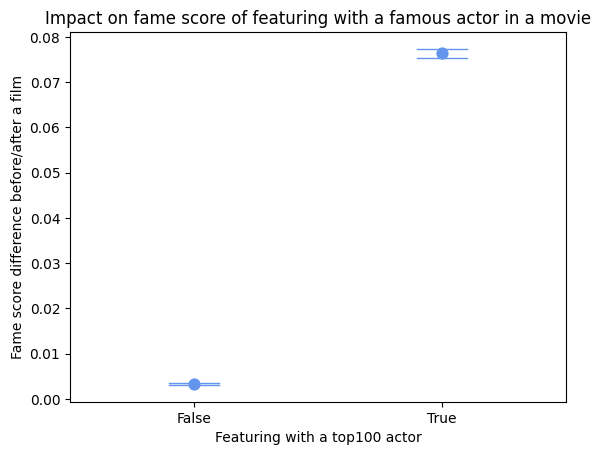

In [48]:
sns.pointplot(data=actor_feats, x='with_top100', y='fameScore_diff', color='cornflowerblue', 
              err_kws={'linewidth': 1}, linestyles='none', capsize=0.2)
plt.title('Impact on fame score of featuring with a famous actor in a movie')
plt.ylabel('Fame score difference before/after a film')
plt.xlabel('Featuring with a top100 actor');

In [36]:
stats.ttest_ind(actor_feats.query('with_top100==True')['fameScore_diff'].values, actor_feats.query('with_top100==False')['fameScore_diff'].values)

TtestResult(statistic=148.94898882913571, pvalue=0.0, df=998800.0)

The group featuring with famous actors has a higher fame increase mean, though small, than the other one but the confidence intervals are not overlapping meaning that the null hypothesis stating that "Portraying in a film with a celebrity does not improve your fame score" can be rejected. This is confirmed through a t-test their means yielding a p-value of 0. \ These results motivate further analysis of what relations between actors influence the fame score evolution. Moreover, matching probably should be used as to compare group that are comparable, mitigating effects of confounders. Indeed, it could be that mostly already rising actors play with famous ones, to not hire only celebrities weighting more on the budget...

### 2.2 Past genres Analysis

Here, we would like to study the relation between the number of genres an actor played in and its fame score

In [37]:
def get_genre_diversity(df):
    '''
    This function returns the number of different genres assigned to a movie
    '''
    df = df.sort_values('release_date')
    return pd.DataFrame({'wikiID':df['wikiID'].values,
                         'genre_diversity':[len(np.unique(np.hstack(df.iloc[:i+1]['genre'].values))) for i in range(df.shape[0])]})

# compute a dataframe with actor informations for each film with fame and number of past genres
actor_genres = cmu_character[['wikiID','actor_name','freebase_actorID','fameScore','release_date']].merge(cmu_movies[['wikiID','genre']])
actor_genres['genre'] = actor_genres['genre'].apply(lambda x : x[:3])
actor_genres = actor_genres.merge(actor_genres.groupby('freebase_actorID').apply(get_genre_diversity).reset_index(level=0), on=['wikiID','freebase_actorID'])
actor_genres.head()

,wikiID,actor_name,freebase_actorID,fameScore,release_date,genre,genre_diversity
0,26147476,Adam Carolla,/m/010p3,0.164063,1999-01-01,[Comedy],1
1,26147476,Kathleen Robertson,/m/02l74w,0.500778,1999-01-01,[Comedy],9
2,26147476,Kelly Macdonald,/m/02tr7d,0.616065,1999-01-01,[Comedy],10
3,26147476,Johnathon Schaech,/m/076bgw,0.479607,1999-01-01,[Comedy],12
4,26147476,Eric Mabius,/m/07j844,0.652867,1999-01-01,[Comedy],6


Let's now use a scatter plot between the genre diversity and the fame score, adding the best fitting line.

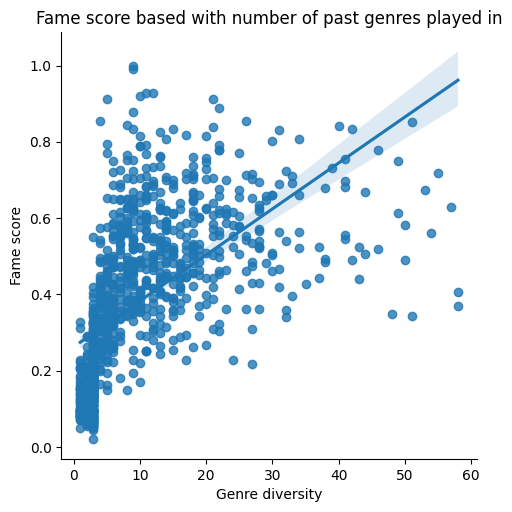

In [38]:
# we use a sample from the dataframe for clarity purposes

sns.lmplot(data=actor_genres.sample(1000), x='genre_diversity', y='fameScore')
plt.title('Fame score based with number of past genres played in')
plt.xlabel('Genre diversity')
plt.ylabel('Fame score')
plt.show()

We can now compute a linear regression model to see if there is a significant relation between the genre diversity and the fame score.

In [39]:
mod = smf.ols(formula='fameScore ~ genre_diversity', data=actor_genres)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              fameScore   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                 1.841e+05
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:58:28   Log-Likelihood:             1.2459e+05
No. Observations:              331169   AIC:                        -2.492e+05
Df Residuals:                  331167   BIC:                        -2.492e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2579      0.000    6

Using statsmodels package we fit a line to the data and find a coefficient of 0.0119 for the genre diversity with a p-value rejecting the null hypothesis. This motivates further analysis to assess wether or not we only observe a correlation rather than a causation. In case of causality, it would mean that the actor should play in a broad genre of movies to maximize its fame score.

### 2.2 Persona Analysis

The goal in this part is to obtain the relation between actor characteristics and the kind of chararcters they play (persona) when they have a big fame score. To do that we first, we only select in the table the row with full usefull data for this analysis andwe look at the distribution of the fame score.

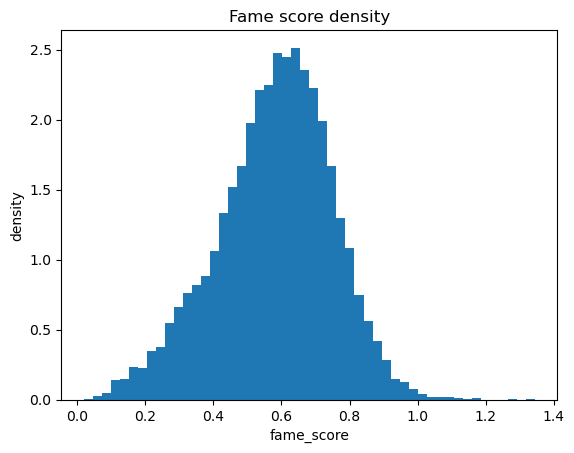

In [27]:
cmu_chara_persona = cmu_character[['actor_gender','actor_height','actor_ethnicity','actor_age_at_release','persona','fameScore']].copy()
cmu_chara_persona = cmu_chara_persona.dropna()

#We transform the persona dtype to str because we don't want to interpret it as numbers but as a class name
cmu_chara_persona['persona'] = cmu_chara_persona['persona'].apply(lambda x : str(int(x)))

plt.hist(cmu_chara_persona['fameScore'],density=True,bins=50)
plt.title('Fame score density')
plt.xlabel('fame_score')
plt.ylabel('density')
plt.show()

In [28]:
#We only take actors with a big enough fameScore to see the personas actors tends to play when they have a big fameScore
cmu_chara_persona = cmu_chara_persona.query('fameScore>0.5')
cmu_chara_persona

,actor_gender,actor_height,actor_ethnicity,actor_age_at_release,persona,fameScore
5,M,1.88,/m/0xnvg,42.0,46,0.550222
12,M,1.85,/m/03bkbh,32.0,35,0.787583
14,M,1.85,/m/03bkbh,33.0,49,0.797858
15,M,1.85,/m/03bkbh,34.0,30,0.758651
19,M,1.85,/m/03bkbh,37.0,27,0.568710
...,...,...,...,...,...,...
331133,M,1.74,/m/033tf_,43.0,2,0.639006
331134,M,1.74,/m/033tf_,43.0,41,0.719212
331135,M,1.74,/m/033tf_,43.0,7,0.689312
331136,M,1.74,/m/033tf_,44.0,2,0.740218


Now we want to look at how the personas and ethnicity are distributed among the actors. If we see that we have personas or ethnicity that are not present enough we will get rid of them since they will not be significant enough for our analysis.

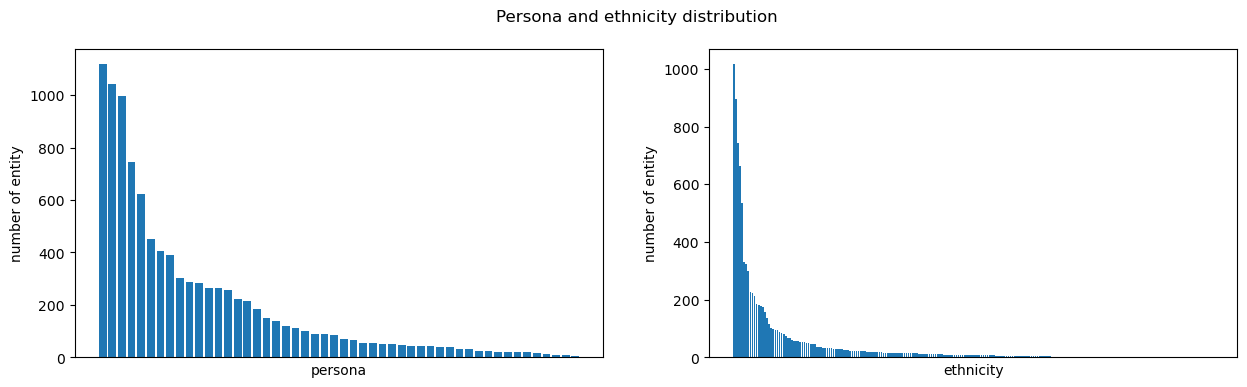

In [29]:
persona_count = cmu_chara_persona[['persona','actor_ethnicity']].groupby('persona',as_index=False).count().rename(columns={'actor_ethnicity':'count'})
persona_count.sort_values('count',inplace=True,ascending=False)
ethnicity_count = cmu_chara_persona[['persona','actor_ethnicity']].groupby('actor_ethnicity',as_index=False).count().rename(columns={'persona':'count'})
ethnicity_count.sort_values('count',inplace=True,ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
fig.suptitle('Persona and ethnicity distribution')

axes[0].bar(persona_count['persona'],persona_count['count'])
axes[1].bar(ethnicity_count['actor_ethnicity'],ethnicity_count['count'])

for ax in axes:
    ax.set_xticks([])

axes[0].set_xlabel('persona')
axes[1].set_xlabel('ethnicity')
axes[0].set_ylabel('number of entity')
axes[1].set_ylabel('number of entity');

We see that we have a lot of personna and ethnicity with very few actors. We will drop them from our dataset.

In [30]:
# We decide to take only the ones with more than 50 entities
persona_count = persona_count.query('count >= 50')
ethnicity_count = ethnicity_count.query('count >= 50')

# We keep only the rows with persona and the ethnicity we're interested in 
cmu_chara_persona = cmu_chara_persona.merge(persona_count['persona'],on='persona',how='right')
cmu_chara_persona = cmu_chara_persona.merge(ethnicity_count['actor_ethnicity'],on='actor_ethnicity',how='right')
cmu_chara_persona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7545 entries, 0 to 7544
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   actor_gender          7545 non-null   object 
 1   actor_height          7545 non-null   float64
 2   actor_ethnicity       7545 non-null   object 
 3   actor_age_at_release  7545 non-null   float64
 4   persona               7545 non-null   object 
 5   fameScore             7545 non-null   float64
dtypes: float64(3), object(3)
memory usage: 353.8+ KB


For the further analysis, the '/' in the actor_ethnicity id will cause problem to the algorithm. We decide to change them to a code_number here.

In [31]:
ethnicity_code_nbr = ethnicity_count['actor_ethnicity'].reset_index(drop=True).reset_index().rename(columns={'index':'ethni_nbr'})
cmu_chara_persona = cmu_chara_persona.merge(ethnicity_code_nbr,on='actor_ethnicity').drop(columns='actor_ethnicity')
cmu_chara_persona

,actor_gender,actor_height,actor_age_at_release,persona,fameScore,ethni_nbr
0,M,1.78,31.0,2,0.612459,0
1,M,1.78,37.0,2,0.634645,0
2,M,1.78,43.0,2,0.731950,0
3,M,1.78,52.0,2,0.600906,0
4,M,1.78,54.0,2,0.654978,0
...,...,...,...,...,...,...
7540,M,1.75,45.0,43,0.652496,36
7541,M,1.75,47.0,43,0.626584,36
7542,M,1.71,32.0,43,0.860269,36
7543,M,1.70,26.0,43,0.501680,36


We can now separate the categorical values with the get_dummies function.

In [33]:
cmu_chara_persona_analysis = pd.get_dummies(cmu_chara_persona,columns=['persona','actor_gender','ethni_nbr'])

Finally, a logistic regression is performed for each persona. Here is the example for persona_5. We first perform the regression with all the caracteristics and then remove the the ones without influence to play this persona.

In [34]:
persona_count.sort_values('persona')

p = 5 # logistic model done for persona_5
persona = 'persona_'+str(p)
cmu_chara_persona_analysis[persona] = cmu_chara_persona_analysis[persona].astype(int)

mod = smf.logit(formula=persona+' ~  C(actor_gender_M) + actor_age_at_release + actor_height +' + 
            'C(ethni_nbr_0) + C(ethni_nbr_1) + C(ethni_nbr_2) + C(ethni_nbr_3) +'+
            'C(ethni_nbr_4) + C(ethni_nbr_5) + C(ethni_nbr_6) + C(ethni_nbr_7) +'+ 
            'C(ethni_nbr_8) + C(ethni_nbr_9) + C(ethni_nbr_10) + C(ethni_nbr_11) +'+ 
            'C(ethni_nbr_12) + C(ethni_nbr_13)', 
            data=cmu_chara_persona_analysis)

res = mod.fit()


high_p_values = res.pvalues[res.pvalues > 0.05].index #we only keep relevant features
high_p_values = high_p_values.drop('Intercept', errors='ignore')

new_formula = persona + ' ~ ' + ' + '.join([col for col in mod.exog_names if col not in high_p_values][1:]) #new formula for regression
new_formula = new_formula.replace('[T.True]', '')

new_mod = smf.logit(formula=new_formula, data=cmu_chara_persona_analysis)
new_res = new_mod.fit()

print(new_res.summary())
# res = [res, mod.fit()]

Optimization terminated successfully.
         Current function value: 0.114216
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.115239
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              persona_5   No. Observations:                 7545
Model:                          Logit   Df Residuals:                     7539
Method:                           MLE   Df Model:                            5
Date:                Fri, 17 Nov 2023   Pseudo R-squ.:                  0.1226
Time:                        12:12:27   Log-Likelihood:                -869.48
converged:                       True   LL-Null:                       -990.96
Covariance Type:            nonrobust   LLR p-value:                 1.788e-50
                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------